# Simplicial complex analysis

#### Author: Ross S. Walker

In this Jupyter notebook we first import the core area overlap data from each season and transform it into a usable form. Then, we construct the filtered simplicial complexes as detailed in the main text, and compute their persistent homology using the Gudhi package. We then implement and compute the maximal simplicial degree centrality, as defined in Serrano and Gómez (2020), and check how the centrality of a simplex is related to simplx size, immigrant proportion and average age. Finally, we implement the filtration complementarity index, as outlined in the main text, and examine how this varies with the fruit abundance index and other associated statistics. 

### Importing packages

In [3]:
import gudhi   #For the simplicial analysis
import pandas as pd
import itertools
import numpy as np
import json  
import scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from itertools import chain, combinations

### Defining the filtered simplicial complexes

In [5]:
#First defining some functions for the conversion of data into the correct form for simplicial analysis

def go_to_numbers(set_list_names):
    unique = []
    num_interactions = len(set_list_names)
    for i in range(num_interactions):
        interaction = set_list_names[i]
        for j in range(len(interaction)):
            if interaction[j] not in unique:
                unique.append(interaction[j])
    unique = sorted(unique) #Alphabeticalising
    N = len(unique)
    dict_keys = unique
    dict_vals = range(N)
    dictionary = {dict_keys[i]: dict_vals[i] for i in range(N)}

    set_list = [None] * num_interactions
    
    for i in range(num_interactions):
        interaction = set_list_names[i]
        k = len(interaction)
        interact_indices = [None] * k
        for j in range(k):
            interact_indices[j] = dictionary[interaction[j]]
        set_list[i] = interact_indices
    
    return set_list, N, dictionary, unique 

#For imposing the restriction of maximal simplex size

def filter_sizes(set_list, w_vals, max_size, min_size = 1):
    num_interactions = len(set_list)
    set_list_filtered = set_list.copy()
    w_vals_filtered = w_vals.copy()
    for i in reversed(range(num_interactions)):
        if len(set_list_filtered[i]) <= min_size or len(set_list_filtered[i]) > max_size:
            set_list_filtered.remove(set_list_filtered[i])
            w_vals_filtered.remove(w_vals_filtered[i]) #This may be problematic if two sets have the same w value, since we are working backwards. Should be fine for now. 
    return set_list_filtered, w_vals_filtered


In [6]:
#Defining the filtration function. 
#In main text, this is given as f(alpha) = 5 - alpha

def filter_func(alpha, alpha_star):
    if (alpha < alpha_star) and (alpha >= 0): 
        f = alpha_star-alpha
    else:
        raise("Error. Filtration parameter out of bounds.")
    return f

In [7]:
#Prefixes for the csv files corresponding to each season:
file_prefixes = ['w12', 'w13', 'w14', 'w15', 'w16', 'w17', 
                 'd12', 'd13', 'd14', 'd15', 'd16', 'd17'] 
#For example, 'd12' is for the dry season of 2012.

In [8]:
#Functions for the full analysis. 
#Note: running this without error requires the data to be in your current working directory

def get_filtered_complex(set_list, w_vals, N, alpha_star = 5, resolution = 100000):
    
    smplx = gudhi.SimplexTree() #Initialising the simplex

    num_simplices = len(set_list)
    filtration_vals = np.linspace(0, alpha_star, resolution)

    #For not iterating over the sets already in the simplex
    sets_not_added = set_list.copy()

    #Get a vector with the simplex sizes
    simplex_size = [None] * num_simplices
    for i in range(num_simplices):
        simplex_size[i] = len(set_list[i])
        
    #First define the set of vertices - the individual spider monkeys
    for i in range(N):
        smplx.insert([i], filtration = 0.0)

    #Add the simplices with the corresponding filtration value - so in order of decreasing redundancy
    for alpha in filtration_vals:
        for group in sets_not_added:
            optimal_w = 1 / (simplex_size[set_list.index(group)])
            minimum = filter_func(alpha, alpha_star) * optimal_w 
            if w_vals[set_list.index(group)] >= minimum:
                smplx.insert(group, filtration = alpha)
                sets_not_added.remove(group)
    return smplx

#This conducts the analysis for n_max between values of 2 and 10. 
#The function is set up in this way for our own comparitative analysis.
def full_analysis(file_prefixes, n_max=10):
    
    num_datasets = len(file_prefixes)
    Bettis = np.zeros([num_datasets, n_max-1, len(range(0,5))]) #Preallocating space for the betti numbers
    complexes_by_set = [None]  * num_datasets #Preallocating space for the simplicial complexes
    dictionaries = [None]  * num_datasets #Preallocating space for the dictionaries, which allow us to keep track of individuals and their indices

    for k in range(num_datasets):
        season = file_prefixes[k]
        filtered_complexes_by_N_max = [None] * (n_max-1)
        sets_ = open('sets_' + season + '.txt', 'r')
        sets= sets_.read()
        sets = sets.replace('\n', ';') 
        sets = sets.replace(' ', ',')
        a = list(map(str.strip, sets.split(';'))) 
        a = a[:-1] #Remove final element, which is empty because of the way we have split up the file
        num_interactions = len(a)
        set_list_names = [None] * num_interactions
    
        for i in range(num_interactions):
            interaction = a[i]
            interaction = list(map(str.strip, interaction.split(','))) 
            set_list_names[i] = interaction
    
        #Take out the computed w values for this season
        ws_ = open('w_' + season + '.txt', 'r')
        ws = ws_.read()
        
        ws = ws.replace('\n', ',') 
        ws = ws[:-1]
        ws = list(map(str.strip, ws.split(','))) 
        w_vals = [float(i) for i in ws]
    
        #Now convert the sets from monkey ID to an alphabetical ennumeration 
        set_list, N, current_dictionary, unique = go_to_numbers(set_list_names)
        dictionaries[k] = current_dictionary

        for n in range(2, n_max+1): #For all values of n_max upto the given input. 
            set_list_, w_vals_ = filter_sizes(set_list, w_vals, n) #Implementing n_max
            smplx = get_filtered_complex(set_list_, w_vals_, N, alpha_star = 5, resolution = 10000) #Using f(alpha)=5-alpha
            smplx.compute_persistence()
            filtered_complexes_by_N_max[n-2] = smplx
            betti_nums = smplx.betti_numbers()
            Bettis[k, n-2, 0] = betti_nums[0]
            if n >= 6:
                Bettis[k, n-2, 1] = betti_nums[1]
                Bettis[k, n-2, 2] = betti_nums[2]
                Bettis[k, n-2, 3] = betti_nums[3]
                Bettis[k, n-2, 4] = betti_nums[4]
            elif n == 5:
                Bettis[k, n-2, 1] = betti_nums[1]
                Bettis[k, n-2, 2] = betti_nums[2]
                Bettis[k, n-2, 3] = betti_nums[3]
            elif n == 4:
                Bettis[k, n-2, 1] = betti_nums[1]
                Bettis[k, n-2, 2] = betti_nums[2]

            elif n == 3:
                Bettis[k, n-2, 1] = betti_nums[1]
                
        complexes_by_set[k] = filtered_complexes_by_N_max
        
    return Bettis, complexes_by_set, dictionaries

Bettis, complexes, dictionaries = full_analysis(file_prefixes)


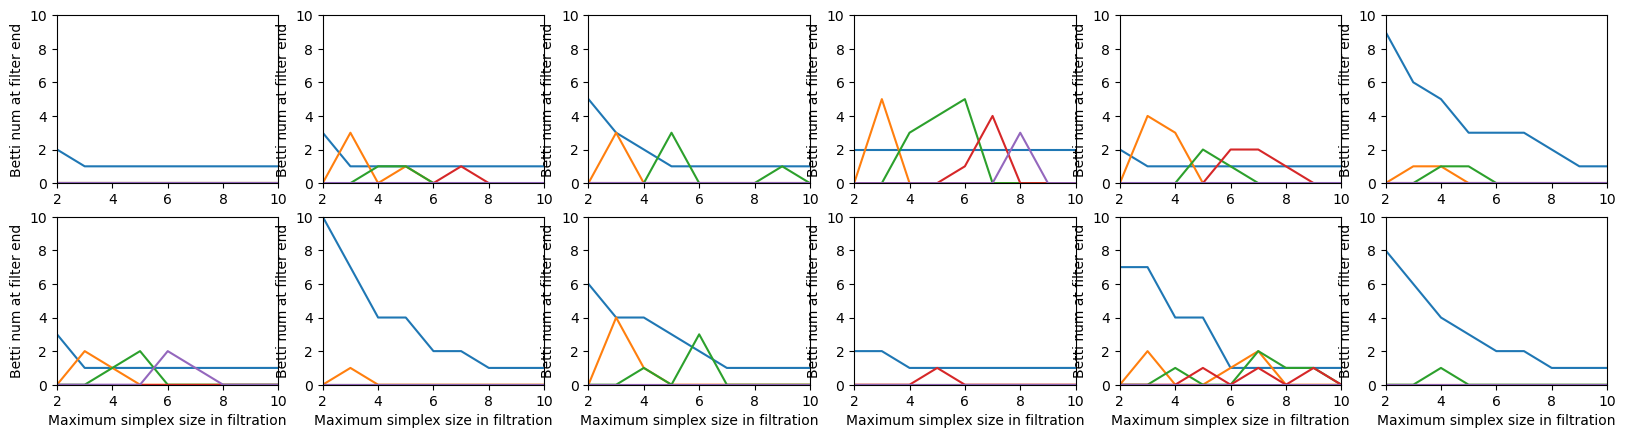

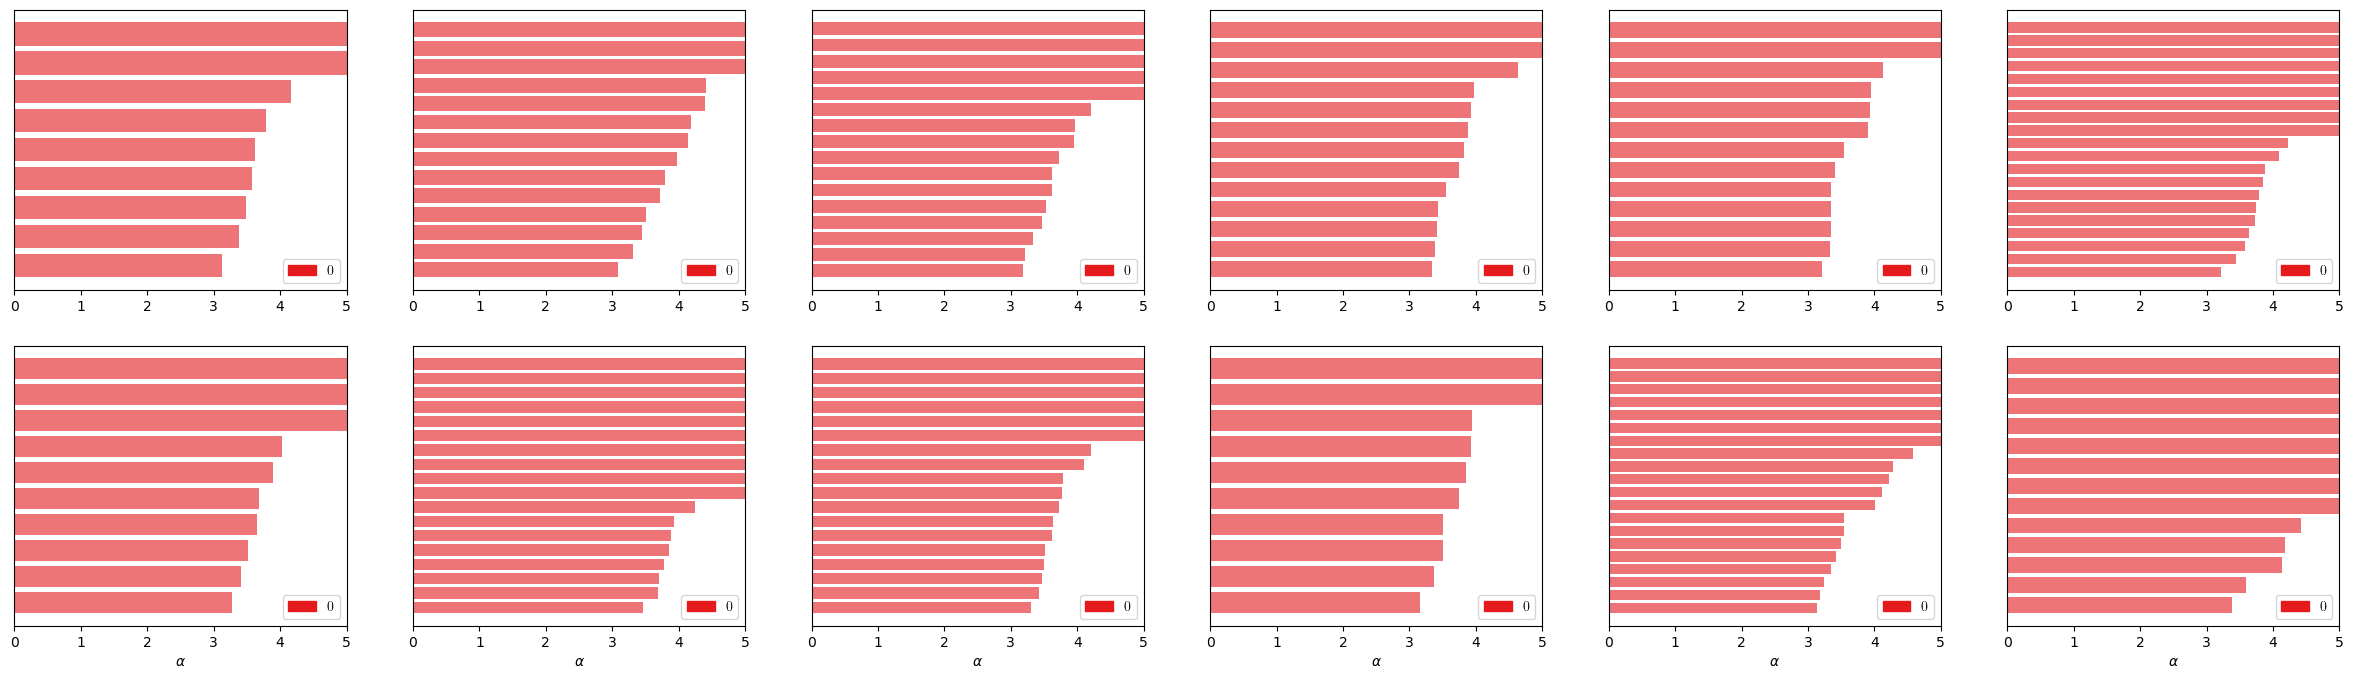

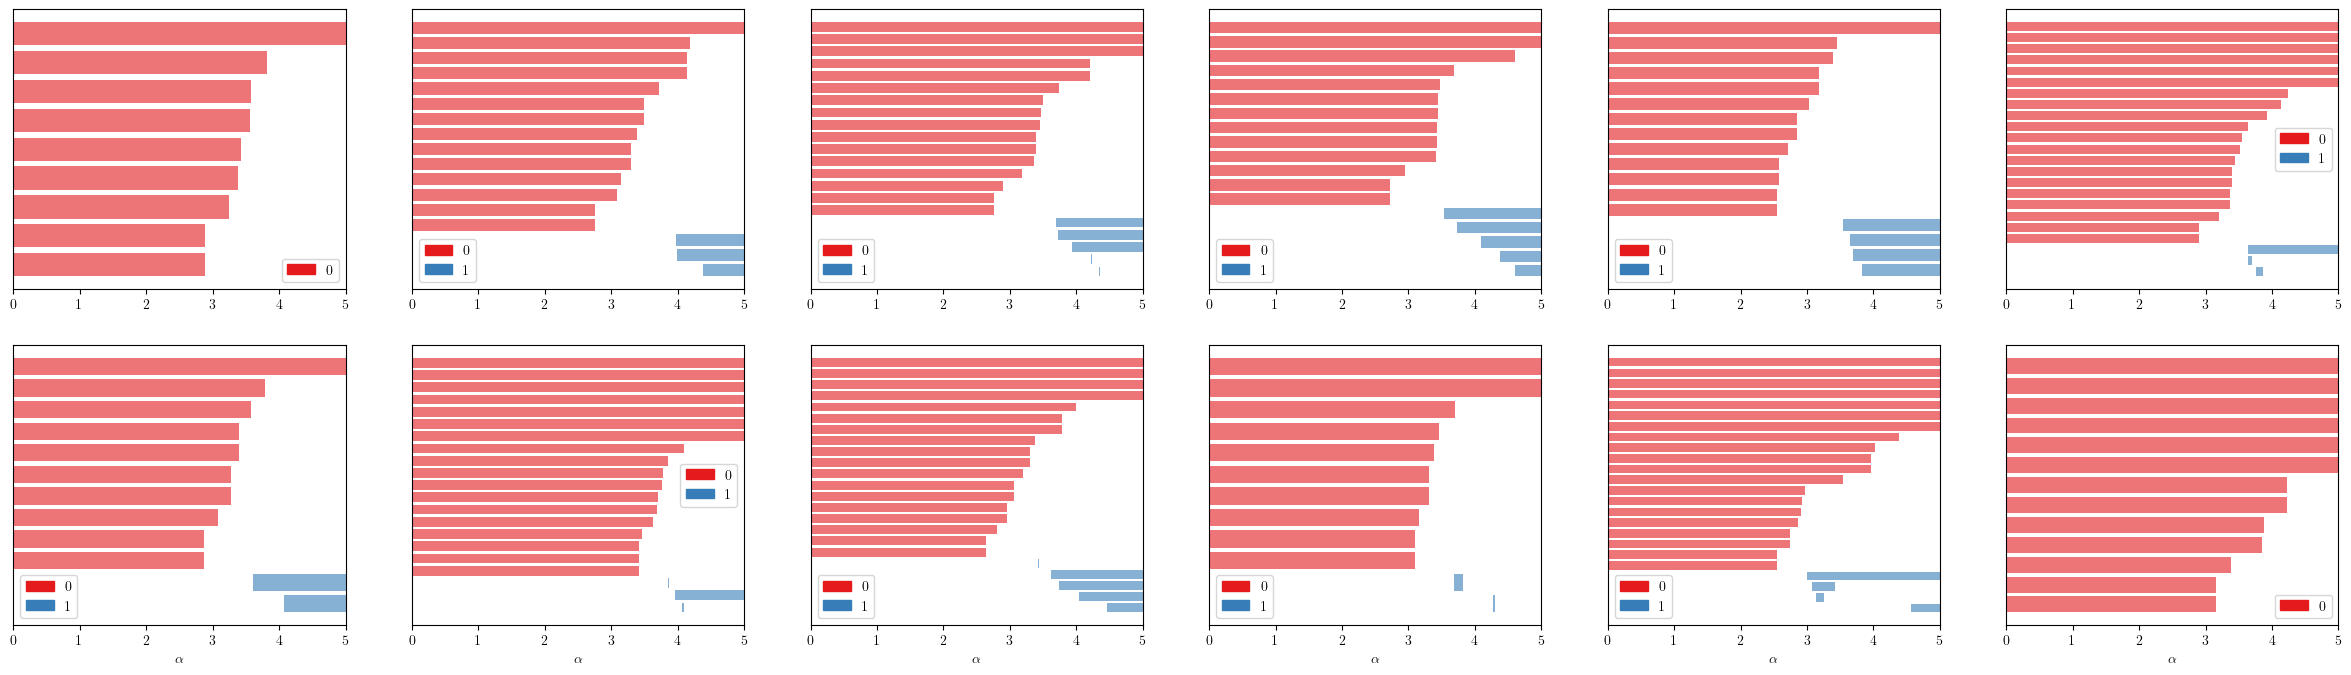

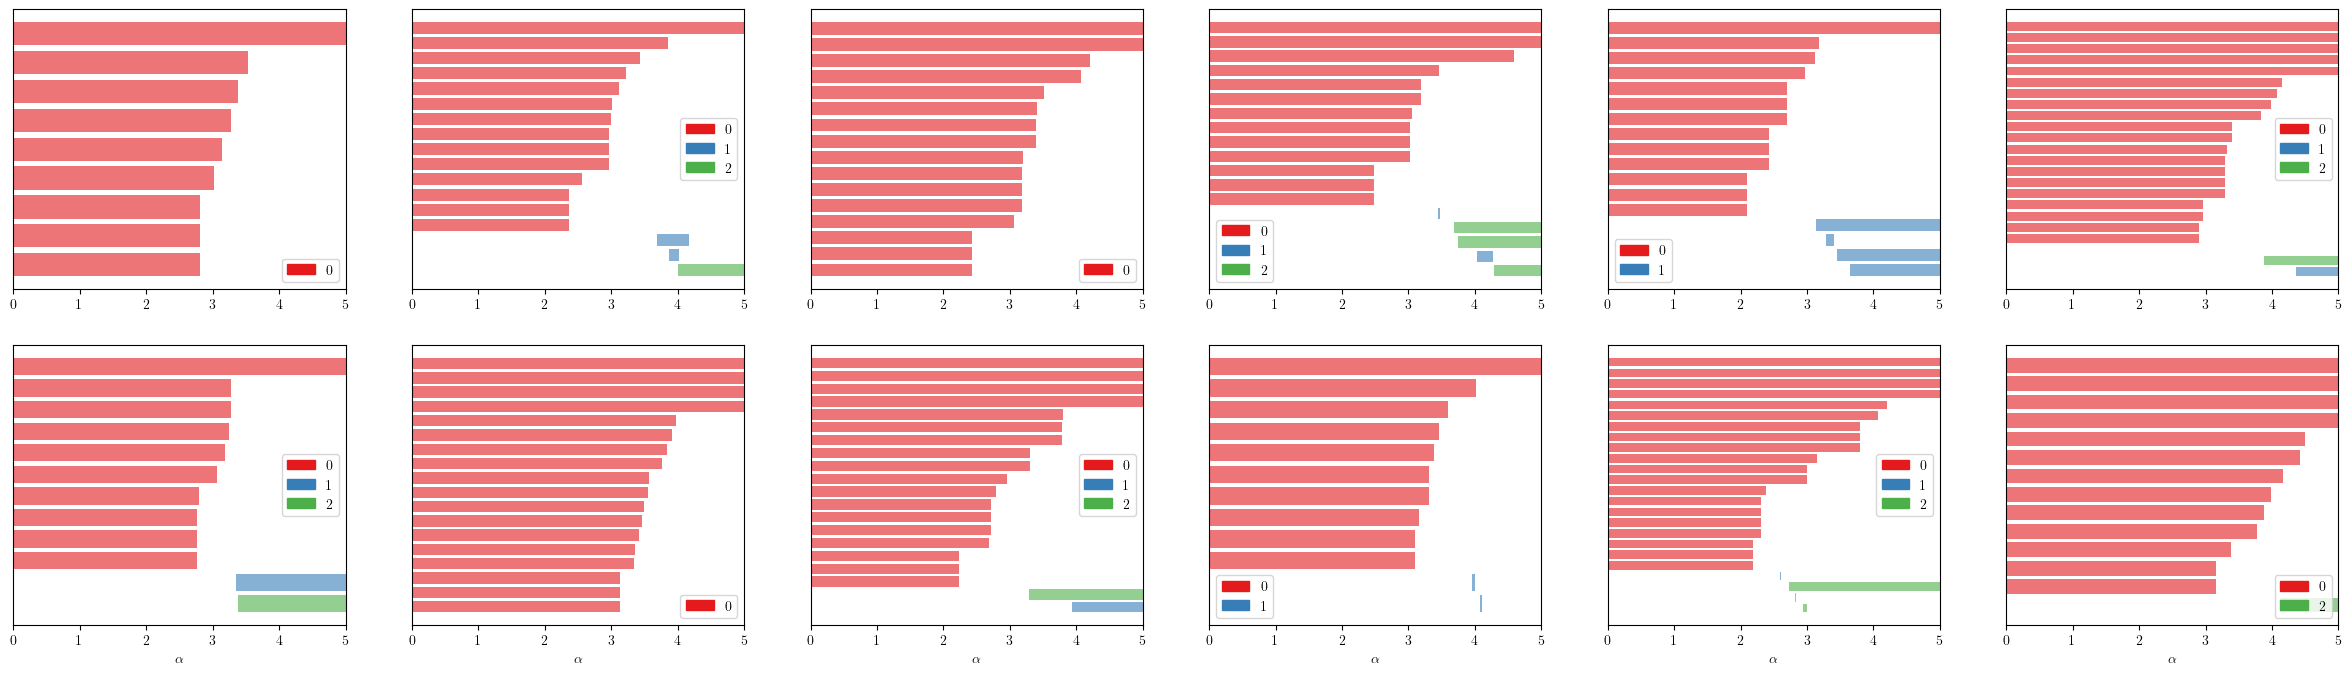

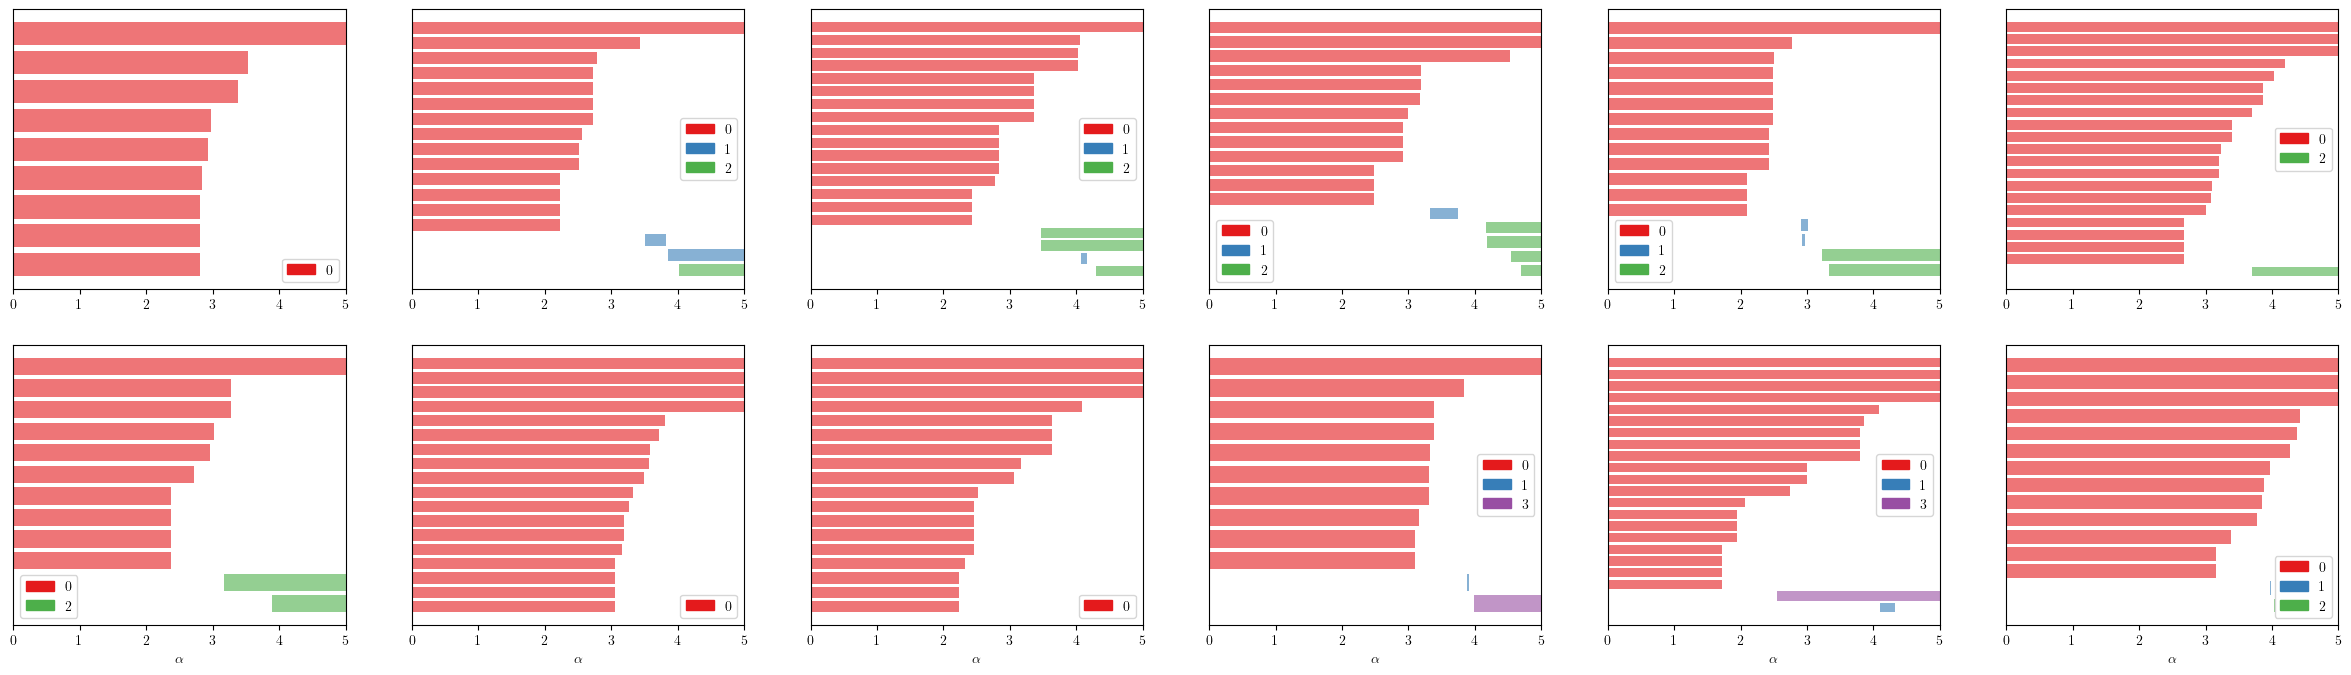

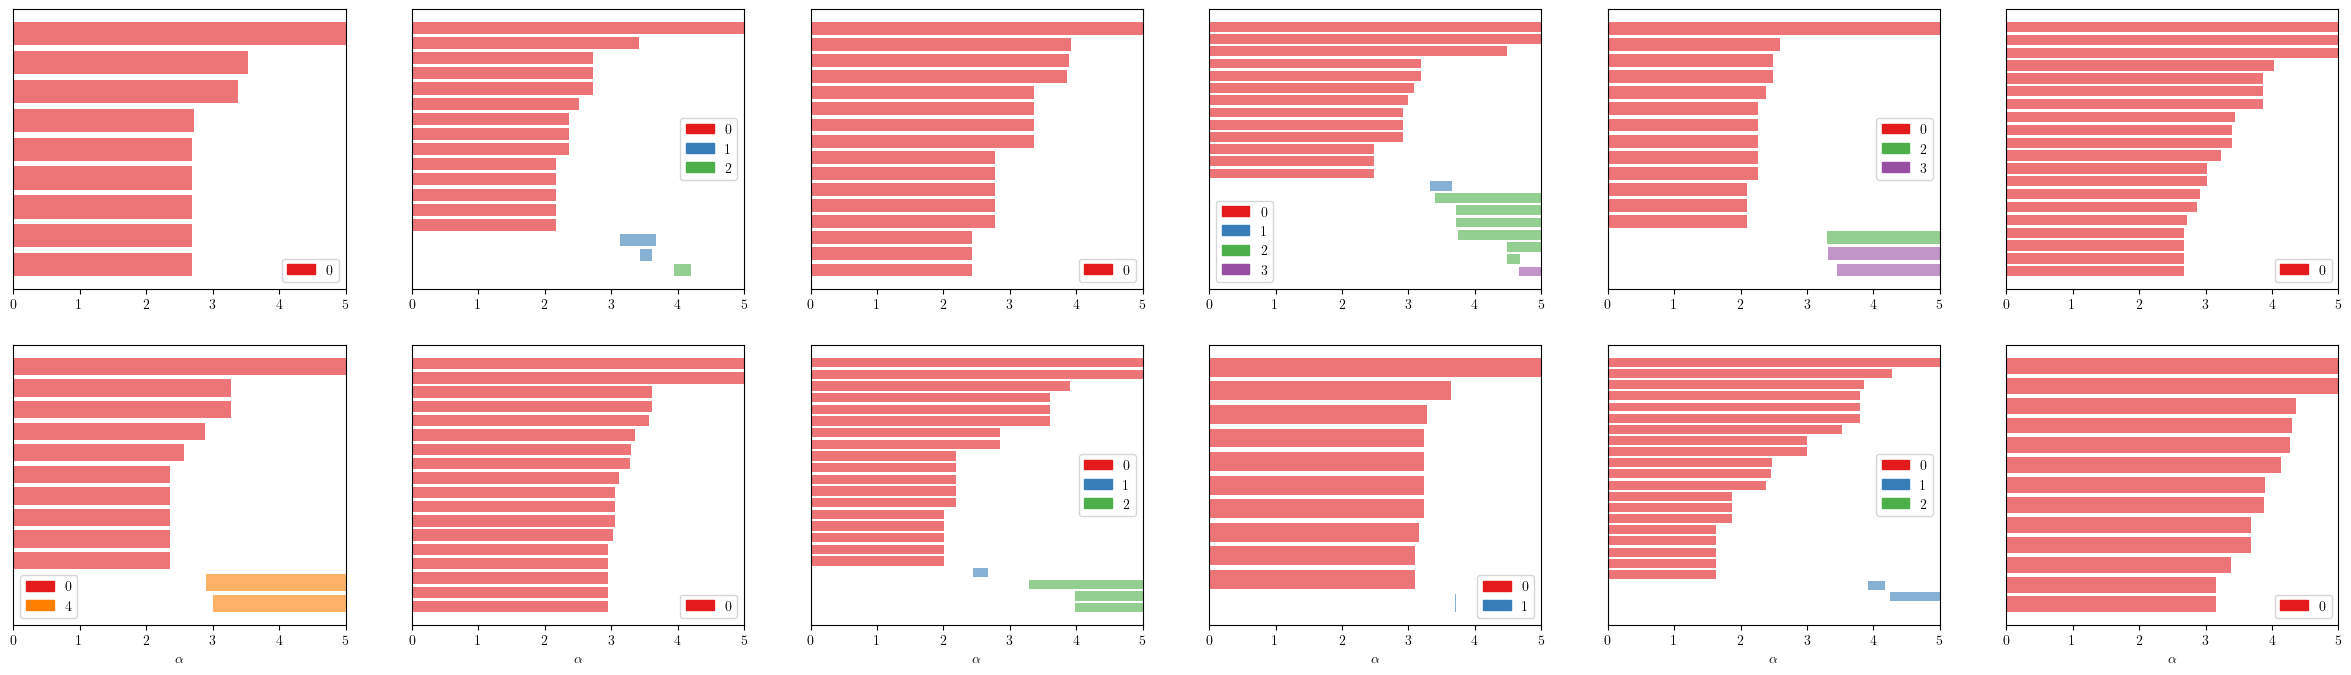

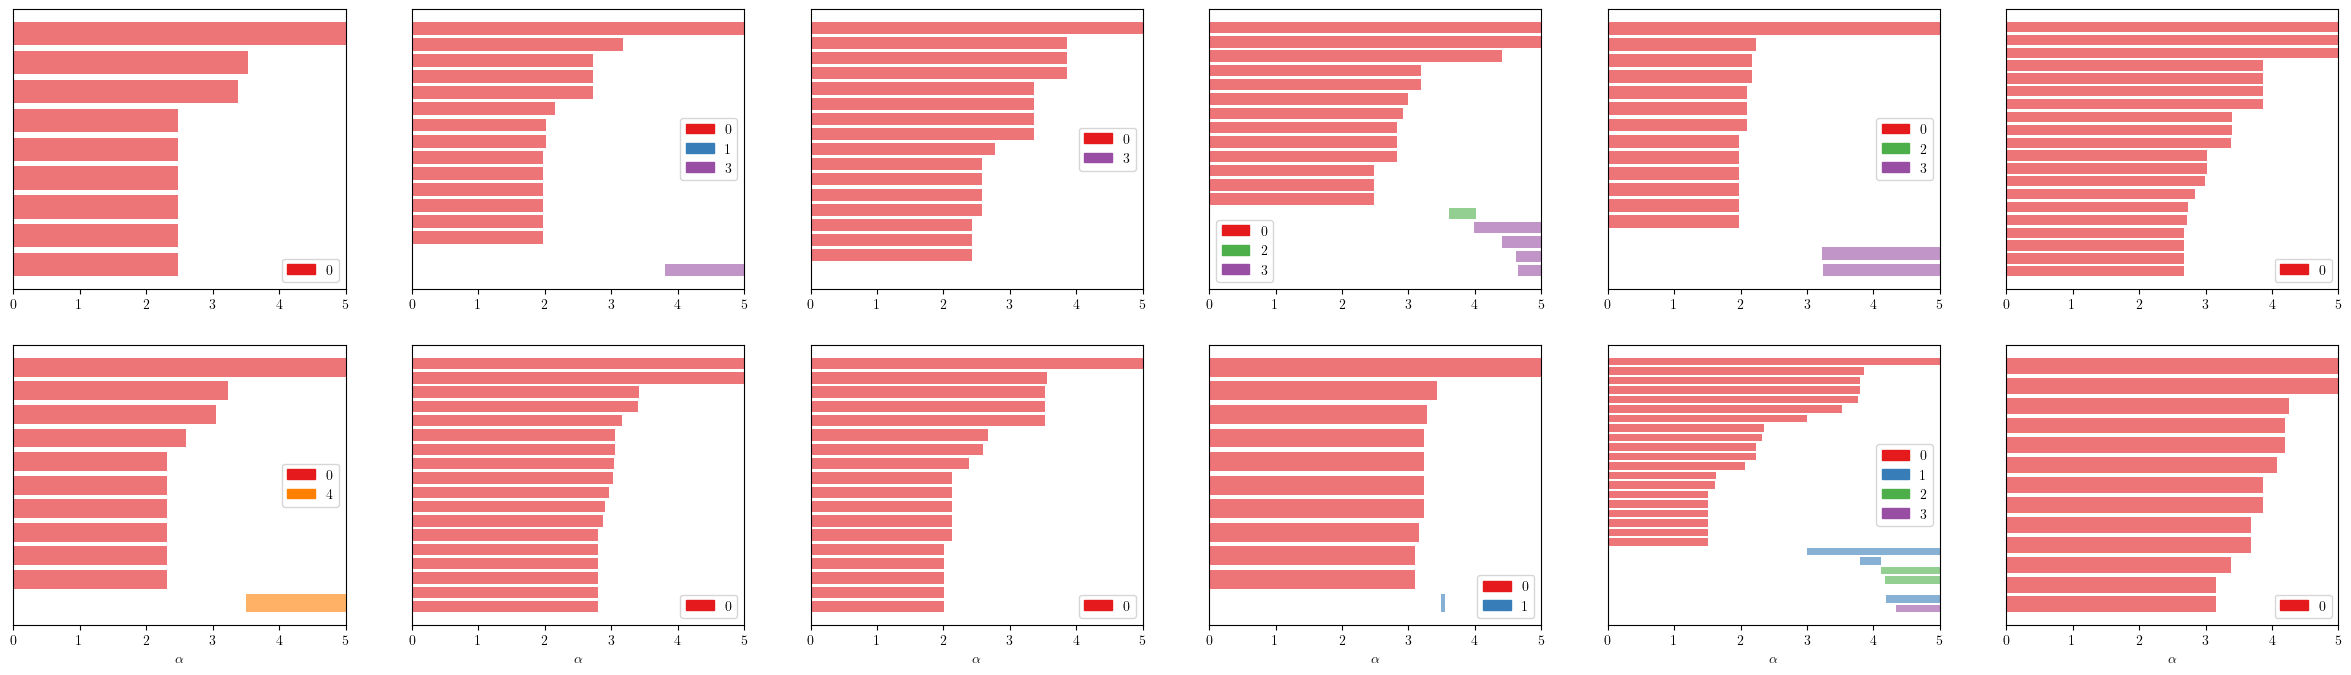

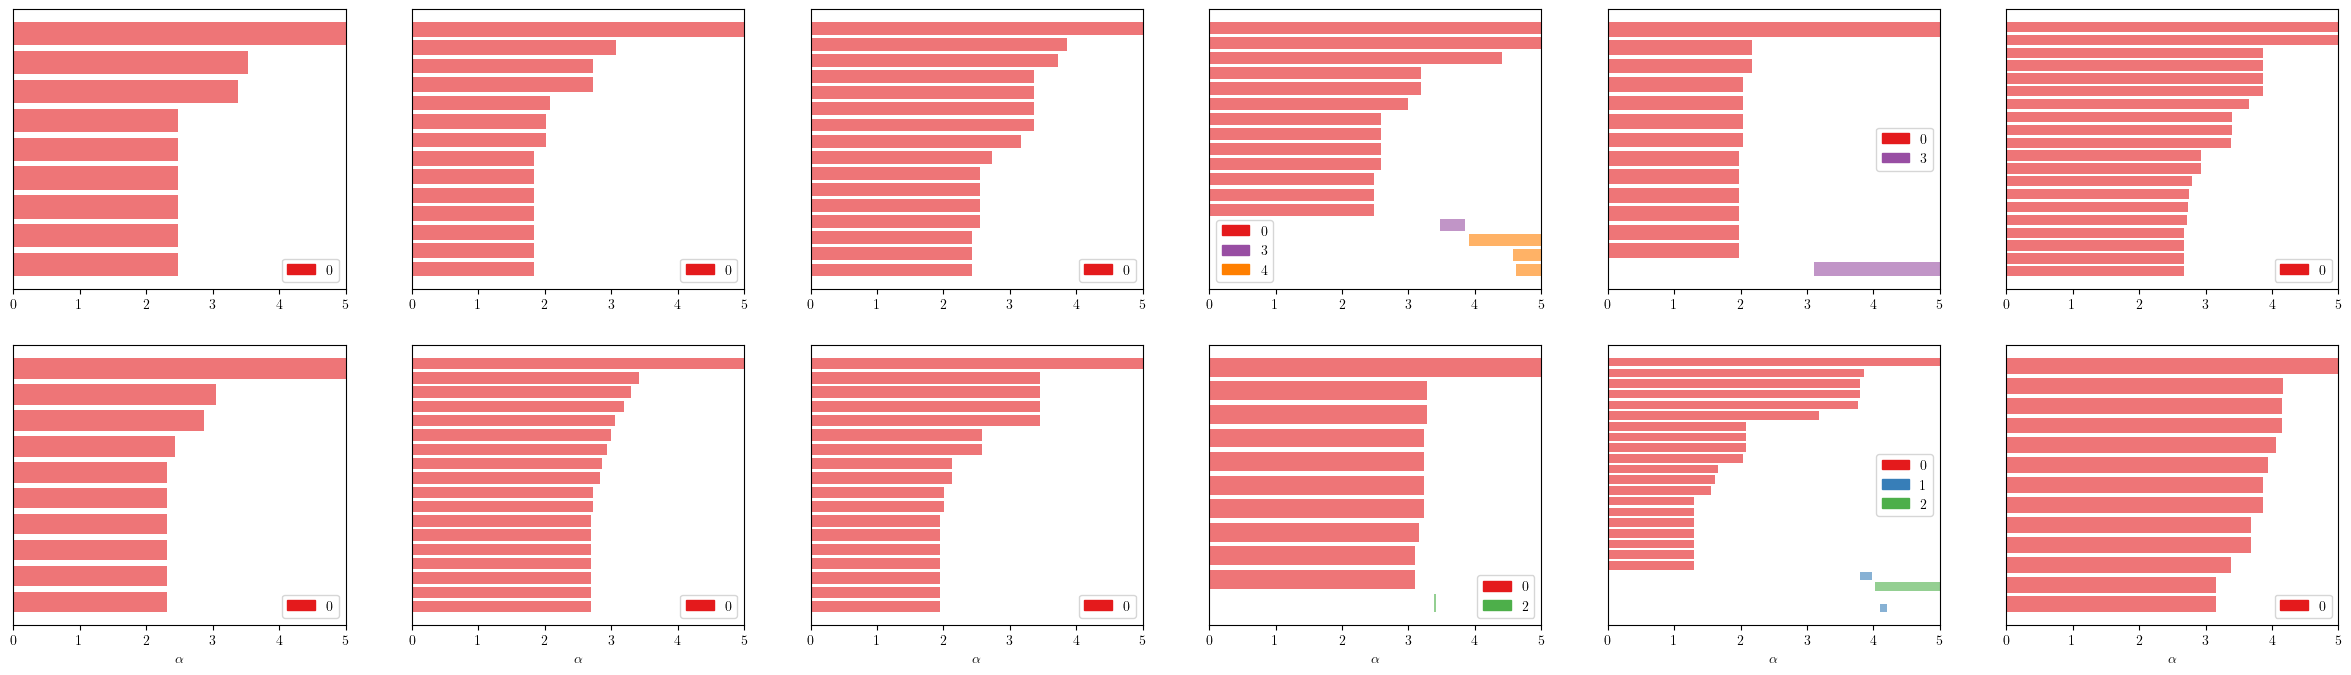

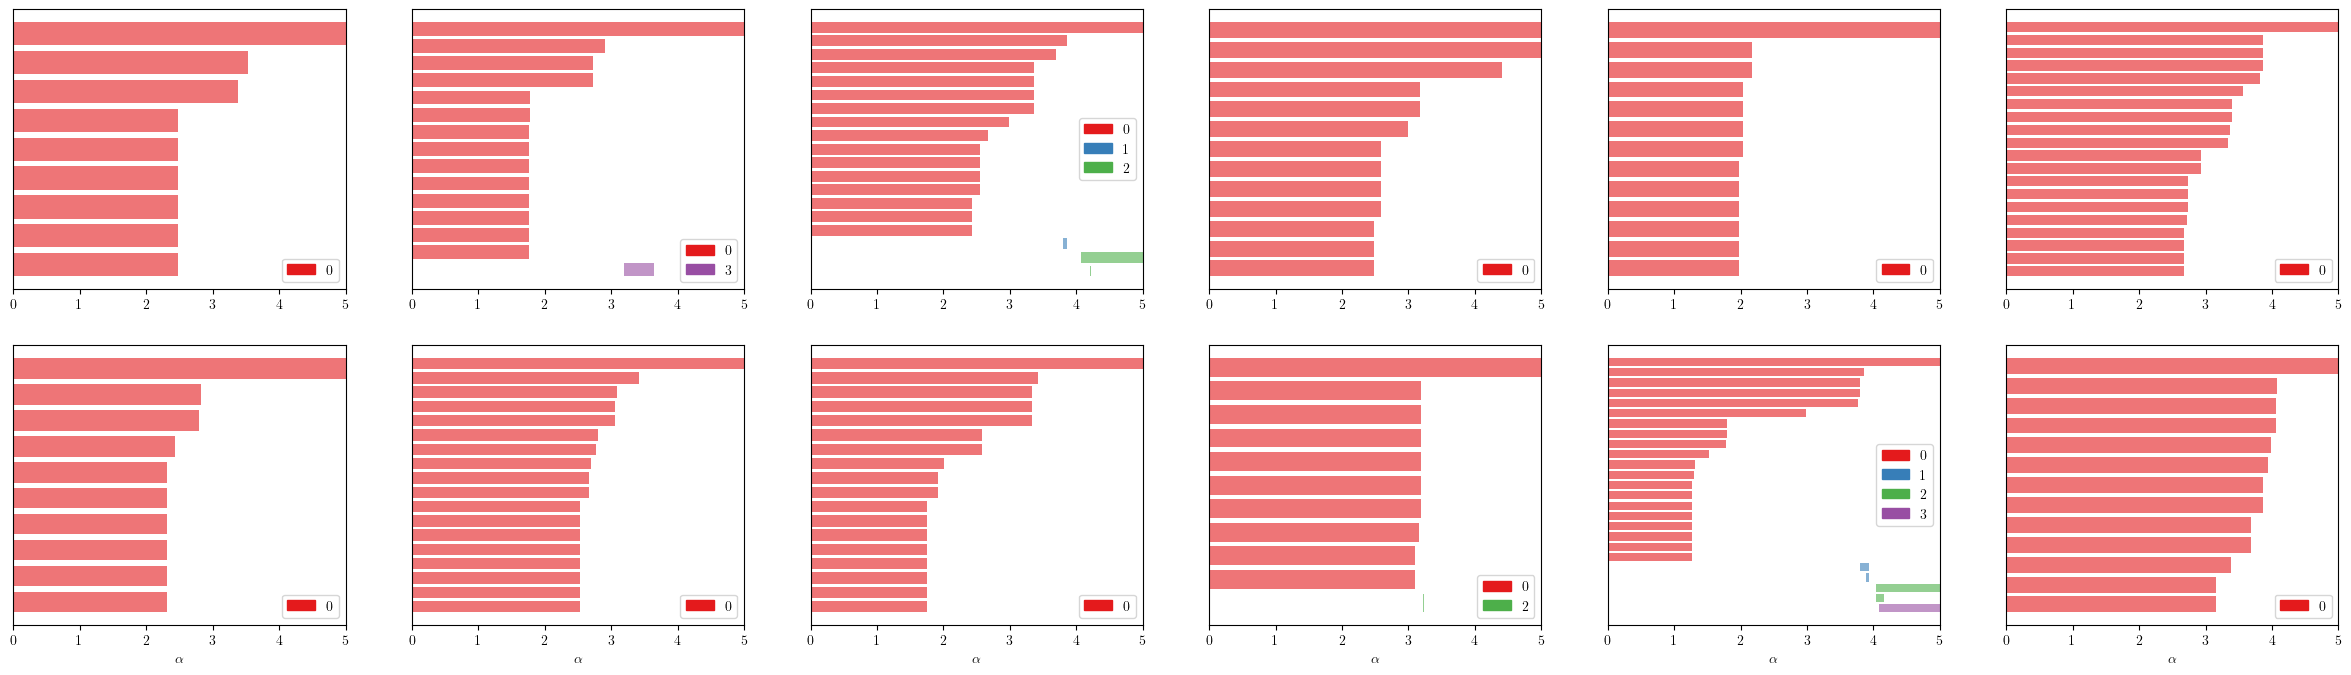

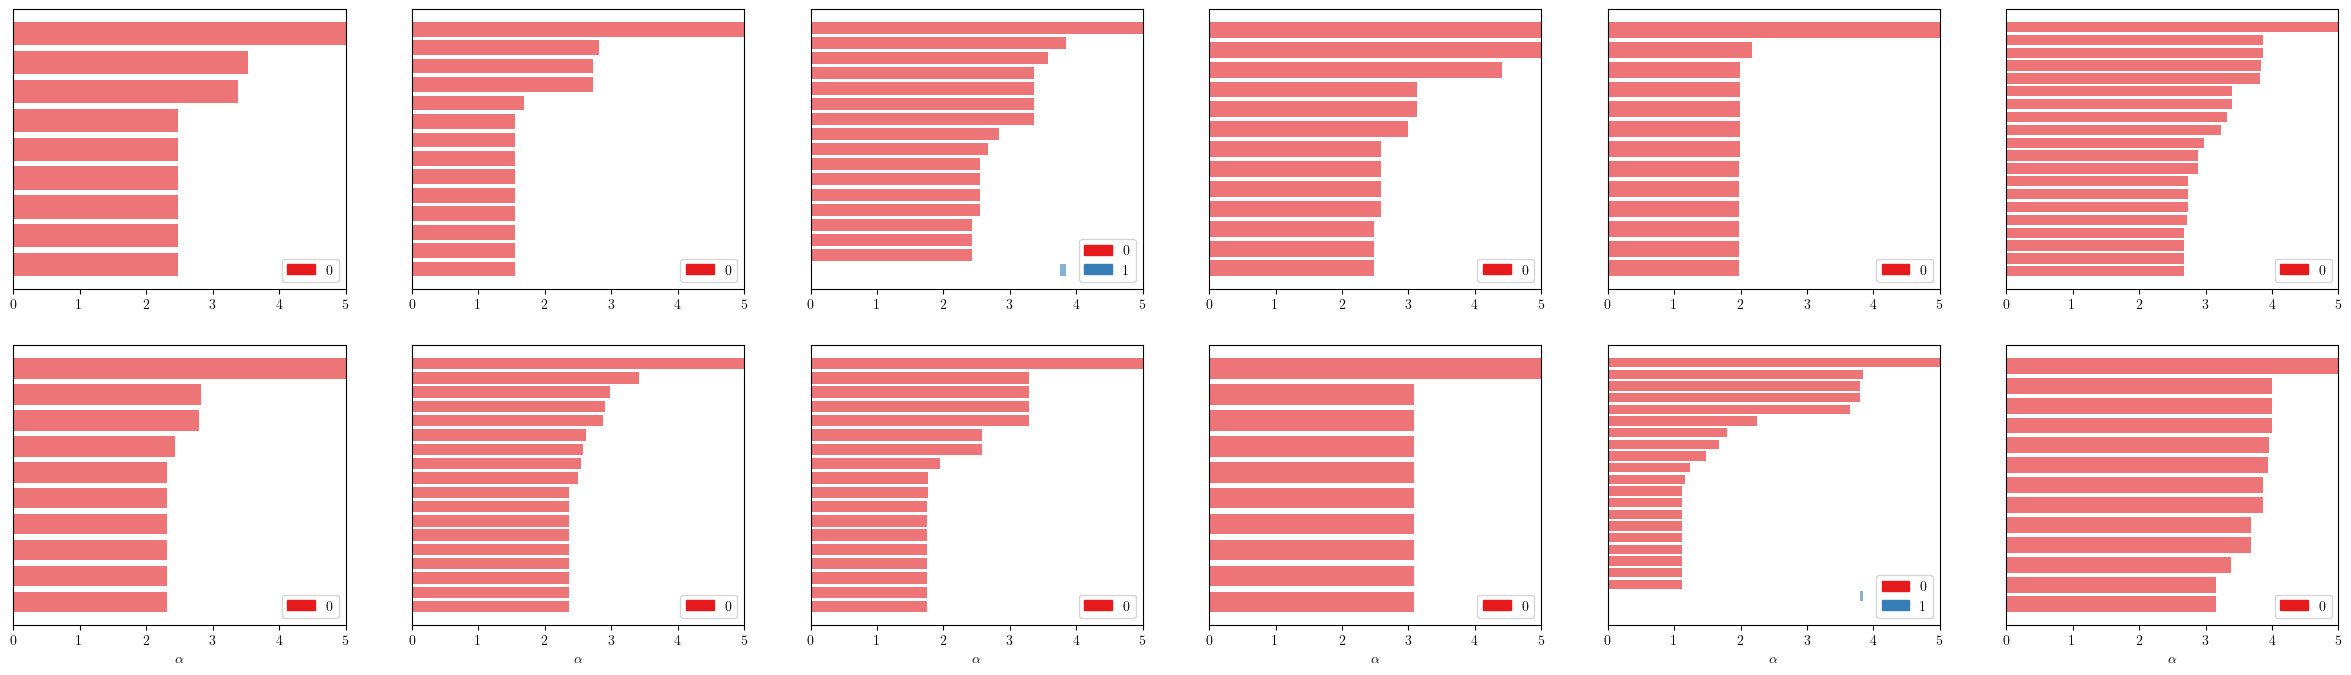

In [9]:
#Plotting the impacts of n_max values and the filtrations for different seasons. 
n_max_largest_tested = 10
n_max_vals = range(2, n_max_largest_tested+1)

fig, axs = plt.subplots(2, 6)
for i in range(6):
    dry_index = i+6
    wet_index = i
    complexes
    axs[1, i].plot(n_max_vals, Bettis[wet_index, :, 0], label = 'Num of connected components')
    axs[1, i].plot(n_max_vals, Bettis[wet_index, :, 1], label = 'Num of holes')
    axs[1, i].plot(n_max_vals, Bettis[wet_index, :, 2], label = 'Num of voids')
    axs[1, i].plot(n_max_vals, Bettis[wet_index, :, 3], label = 'Num of 4-dimensional holes')
    axs[1, i].plot(n_max_vals, Bettis[wet_index, :, 4], label = 'Num of 5-dimensional holes')
    axs[1, i].set_ylabel("Betti num at filter end")
    axs[1, i].set_xlabel("Maximum simplex size in filtration")
    axs[1, i].set_ylim([0, 10])
    axs[1, i].set_xlim([2, 10])


    axs[0, i].plot(n_max_vals, Bettis[dry_index, :, 0], label = 'Num of connected components')
    axs[0, i].plot(n_max_vals, Bettis[dry_index, :, 1], label = 'Num of holes')
    axs[0, i].plot(n_max_vals, Bettis[dry_index, :, 2], label = 'Num of voids')
    axs[0, i].plot(n_max_vals, Bettis[dry_index, :, 3], label = 'Num of 4-dimensional holes')
    axs[0, i].plot(n_max_vals, Bettis[dry_index, :, 4], label = 'Num of 5-dimensional holes')
    axs[0, i].set_ylabel("Betti num at filter end")
    axs[0, i].set_ylim([0, 10])
    axs[0, i].set_xlim([2, 10])
    #gudhi.plot_persistence_barcode(smplx_test.persistence(homology_coeff_field=2), axes=axs[0, i])
    
fig.set_figwidth(20)

for filter_n_max in range(2, 11):
    fig, axs = plt.subplots(2, 6)
    for i in range(6):
        smplx_wet = complexes[i][filter_n_max-2]
        smplx_dry = complexes[i+6][filter_n_max-2]
        
        gudhi.plot_persistence_barcode(smplx_wet.persistence(homology_coeff_field=2), axes=axs[1,i], inf_delta = 50)
        gudhi.plot_persistence_barcode(smplx_dry.persistence(homology_coeff_field=2), axes=axs[0,i], inf_delta = 50)
        axs[0, i].set_xlim([0, 5])
        axs[1, i].set_xlim([0, 5])
        axs[0, i].set_title("")
        axs[1, i].set_title("")
        axs[1, i].set_xlabel("$\\alpha$")

    
    fig.set_figwidth(30)
    fig.set_figheight(8)

### Maximal simplicial degree centrality
Throughout this section we use some of the language introduced/defined in Serrano and Gómez (2020).

To compute the maximal simplicial degree centrality of a q-simplex, we first compute other metrics for a given q-simplex. Firstly, the maximal p-adjacency degree (for $p=0,\dots, q-1$), giving lower order significance, and then the $(h, q+h)$-upper degree, giving higher order significance. 

In [11]:
#Some preliminary functions (mostly for making sure the data formats are fine)

#Convert from a list into a simplex tree object
def list_with_alphas_to_smplx_tree(smplx_list):
    smplx = gudhi.SimplexTree()
    sets = [smplx_list[i][0] for i in range(len(smplx_list))]
    filtrations = [smplx_list[i][1] for i in range(len(smplx_list))]
    for i in range(len(smplx_list)):
        smplx.insert(sets[i], filtration = filtrations[i])
    return smplx

#Remove simplices which appear later in the filtration.
#I.e. above the value of alpha_max.
def chop_filtrations(K, alpha_max):
    simplices = list(K.get_simplices())
    num_simplices = len(simplices)
    Chopped_K_list = [simplices[k] for k in range(num_simplices) if simplices[k][1] <= alpha_max]
    return Chopped_K_list

#For only taking the simplex lists, removing corresponding alpha values
def remove_filter_vals(simplex_list):
    num_faces = len(simplex_list)
    
    for i in range(num_faces):
        smplx = simplex_list[i]
        simplex_list[i] = smplx[0]
        
    return simplex_list

In [12]:

def find_p_adjacent_simplices(sigma, p, K):
    
    #Input should be the set of vertices which are contained in sigma, expressed as a list.
    
    #For simplices to satisfy this adjacency condition with sigma, 
    #they need to be strictly lower p-adjacent 
    #(contain EXACTLY p+1 shared vertices) and not 
    #be contained in a mutual simplex (so they don't both belong to 
    #a p'-simplex where p'=q+q'-p).
    #So overall they share p+1 vertices and are not nested in some larger simplex.

    #Find all sub-simplices of sigma of size p+1. 
    cofaces = list(combinations(sigma, p+1))
    for i in range(len(cofaces)): 
        cofaces[i] = list(cofaces[i])

    cofaces_ = []
    
    for face in cofaces:
        cofaces_ += K.get_star(face)
    cofaces_ = remove_filter_vals(cofaces_)
    cofaces_.sort()
    cofaces_ = list(cofaces_ for cofaces_,_ in itertools.groupby(cofaces_))
    cofaces = [face for face in cofaces_ if len(face) > (p+1)+1] #Only care about significance from higher order to lower order.

    all_coface_simplices = cofaces.copy()
    
    sigma_set = set(sigma) 
    q = len(sigma) - 1

    #Need to find which sets share exactly p+1 many elements with sigma
    cofaces_ = cofaces.copy()
    for face in cofaces_:
        shared_vertices = sigma_set & set(face)
        if len(list(shared_vertices)) != (p + 1) :
            cofaces.remove(face)
    
    #Now we are only left with sets sharing exactly p+1 many elements, none contained in any other. 
    #Now need to check that these remaining are not just nested in some higher order simplex
    cofaces_ = cofaces.copy()
    for face in cofaces_:
        q_ = len(face) - 1
        p_ = q + q_ - p #minimal simplex containing both face and sigma
        p__simplex_only = [set(simplex) for simplex in all_coface_simplices if len(simplex) == p_+1]
        for simplex in p__simplex_only:
            if (sigma_set | set(face)) & simplex == (sigma_set | set(face)):
                cofaces.remove(face)    

    #Need now to deal with maximality. Check that none of these vertices are contained within any other
    cofaces_ = cofaces.copy()
    for face in cofaces_:
        #Get the simplices of that size or more
        to_check = [simplex for simplex in cofaces if len(simplex) >= len(face) and simplex != face]
        face_set = set(face)
        for simplex in to_check:
            if face_set & set(simplex) == face_set: 
                #If here, then there is containment. Remove the contained set.
                cofaces.remove(face)
                break

    
    p_adjacency = len(cofaces)
    
    return p_adjacency
    

In [13]:

def compute_upper_deg(sigma, K):
    dim_K = K.dimension()
    q = len(sigma) - 1
    cofaces_w_alphas = K.get_star(sigma)
    cofaces = remove_filter_vals(cofaces_w_alphas)

    #Ensure maximality
    cofaces_ = cofaces.copy()
    for face in cofaces_:
        face_set = set(face)
        larger_faces = [set(smplx) for smplx in cofaces if len(smplx)>len(face)]
        for larger in larger_faces:
            if (face_set & larger) == face_set:
                cofaces.remove(face)
                break
    U_deg = len(cofaces)
    return U_deg

In [14]:
#Definition 5 in Serrano and Gómez (2020)
def compute_max_simplicial_degree(sigma, K):
    q = len(sigma) - 1
    deg_U = compute_upper_deg(sigma, K)
    deg_A = sum([find_p_adjacent_simplices(sigma, p, K) for p in range(0, q)])
    deg = deg_U + deg_A
    return deg
    

In [15]:
#Example for checking of code - see Figure 3, Example 1 in Serrano and Gómez (2020)

simplices = [[1,4,5,6], [0,1,3,12], [0,1,2,3], [0,1,11], [0,9,10], [1,7,8], [1,2,4], [5,9]]
Ex1_Smplx = gudhi.SimplexTree()

for simplex in simplices:
    Ex1_Smplx.insert(simplex)
    
deg = compute_max_simplicial_degree([0, 1], Ex1_Smplx)


In [16]:
#Maximal Simplicial Degree Centrality, Definition 14 in Serrano and Gómez (2020)

def maximal_degree_centrality(sigma, K):
    degree = compute_max_simplicial_degree(sigma, K)
    num_simplices = K.num_simplices()
    C = degree / (num_simplices - 1) #Normalising by number of simplices in the simplicial complex, minus 1

    return C
    
sigma = [0, 1]
maximal_degree_centrality(sigma, Ex1_Smplx)

0.12727272727272726

In [17]:
#Compute all of the centralities in a given simplicial complex, for given level of minimum redundancy
#returning the individuals in a simplex along with their centrality 

def centrality_lists(K, alpha_max, K_dictionary):
    K = chop_filtrations(K, alpha_max)
    K_ = list_with_alphas_to_smplx_tree(K)
    K = remove_filter_vals(K)
    num_simplices = len(K)
    print(f"Computing centralities with {num_simplices} simplices")
    centralities = [maximal_degree_centrality(K[i], K_) for i in range(num_simplices)]
    map_nums_to_names = {v: k for k, v in K_dictionary.items()}
    K_names = [[map_nums_to_names[K[i][j]] for j in range(len(K[i]))] for i in range(num_simplices)]
    results = [[K_names[i], centralities[i]] for i in range(num_simplices)]
    
    results.sort(key = lambda x: x[1]) #Sorting by the centralities
    return results


#### Subgroup features and corrolation with centralities 


In [19]:
#Map useful for saving and importing files efficiently.

season_to_year = {0: 2012, 
                 1: 2012,
                 2: 2013,
                 3: 2013, 
                 4: 2014, 
                 5: 2014, 
                 6: 2015, 
                 7: 2015, 
                 8: 2016, 
                 9: 2016, 
                 10: 2017,
                 11: 2017}


In [20]:
#Define the sigmoid function, for fitting to the sigmoid-like patterns
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)


n_max = 6

In [21]:
#Preallocate space for the group features:
centralities = [None] * 12
sexes = [None] * 12
ages = [None] * 12
immis = [None] * 12
sizes = [None] * 12

#Import the datafiles - must be in the same directory as this file.
for i in range(6):
    df = pd.read_csv(f'simplicial_data_wet_{season_to_year[2*i]}.csv')
    centralities[i] = list(df["Centrality"])
    sexes[i] = list(df["Proportion of males"])
    ages[i] = list(df["Average age"])
    immis[i] = list(df["Proportion of immigrants"])
    sizes[i] = list(df["Simplex size"])

    df = pd.read_csv(f'simplicial_data_dry_{season_to_year[2*i]}.csv')
    centralities[i+6] = list(df["Centrality"])
    sexes[i+6] = list(df["Proportion of males"])
    ages[i+6] = list(df["Average age"])
    immis[i+6] = list(df["Proportion of immigrants"])
    sizes[i+6] = list(df["Simplex size"])
    

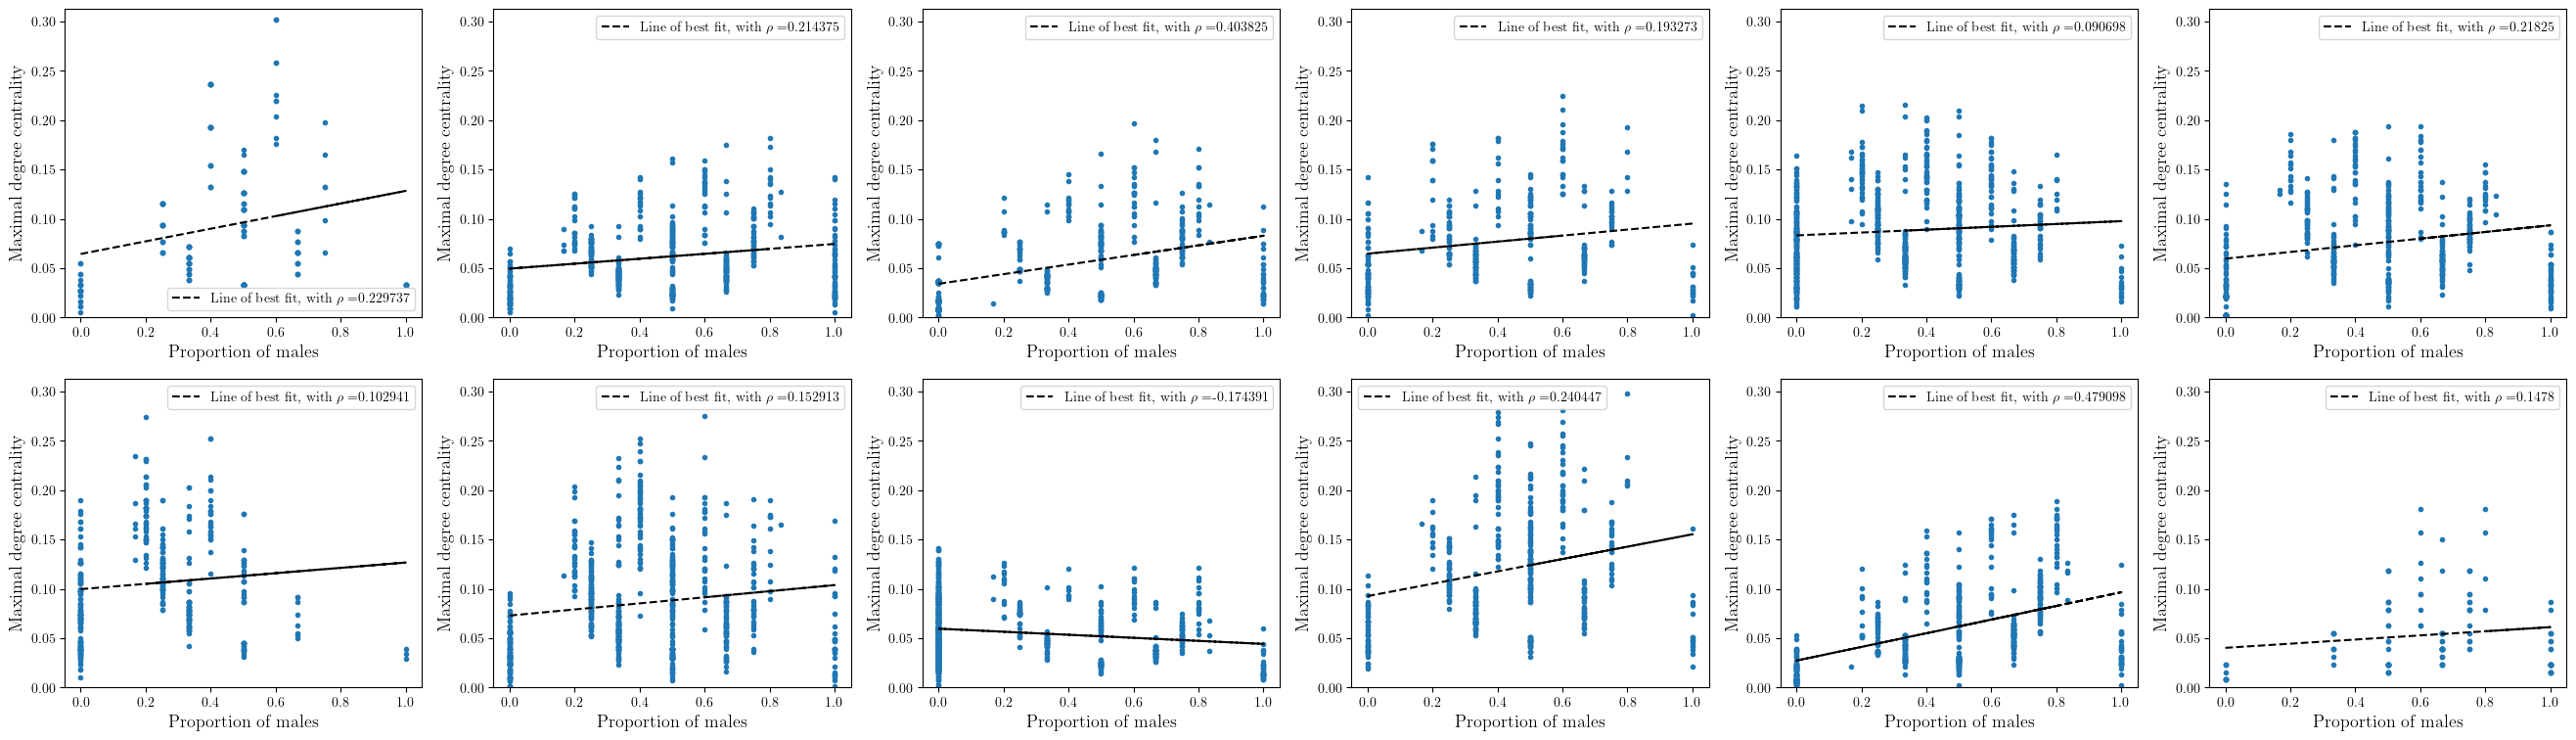

In [22]:
#Plots for sex proportion

fig, ax = plt.subplots(2,6)

max_centrality = 0

for i in range(6):
    #Dry season
    ax[0, i].plot(sexes[i+6], centralities[i+6], '.')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sexes[i+6], centralities[i+6])
    R_squared = r_value ** 2
    poly1d_fn = np.poly1d([slope, intercept])
    ax[0, i].plot(sexes[i+6], poly1d_fn(sexes[i+6]), '--k', label = f"Line of best fit, with $\\rho=${round(r_value, 6)}")
    ax[0, i].set_xlabel("Proportion of males", fontsize=13)
    ax[0, i].legend(fontsize=10)

    max_centrality_here = max(centralities[i+6])
    max_centrality = max([max_centrality_here, max_centrality])

    #Wet season
    ax[1, i].plot(sexes[i], centralities[i], '.')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sexes[i], centralities[i])
    R_squared = r_value ** 2
    poly1d_fn = np.poly1d([slope, intercept])
    ax[1, i].plot(sexes[i], poly1d_fn(sexes[i]), '--k', label = f"Line of best fit, with $\\rho=${round(r_value, 6)}")
    ax[1, i].set_xlabel("Proportion of males", fontsize=13)
    ax[1, i].legend(fontsize=10)

for i in range(6):
    ax[0,i].set_ylim([0, max_centrality+0.01])
    ax[1,i].set_ylim([0, max_centrality+0.01])
    ax[0,i].set_ylabel("Maximal degree centrality", fontsize=13)
    ax[1,i].set_ylabel("Maximal degree centrality", fontsize=13)

fig.set_figwidth(33)
fig.set_figheight(9)


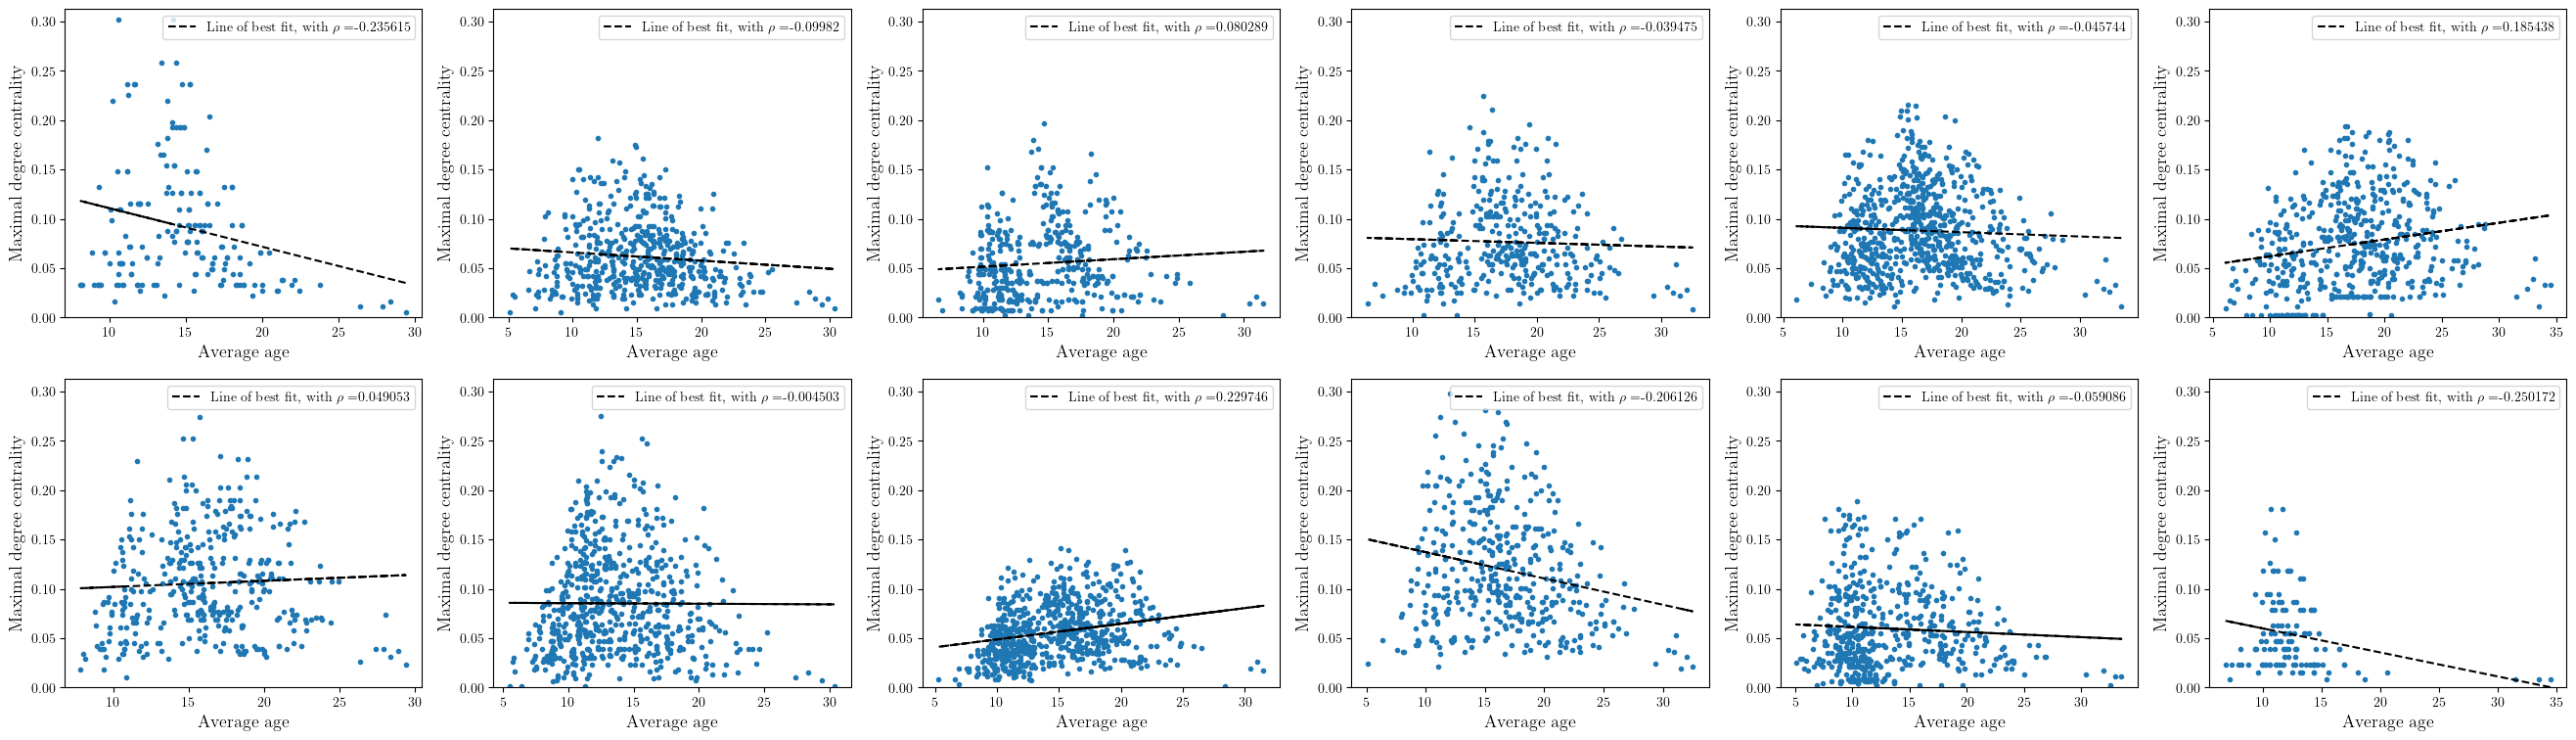

In [23]:
#Plots for average subgroup age
fig, ax = plt.subplots(2,6)

for i in range(6):
    
    ax[0, i].plot(ages[i+6], centralities[i+6], '.')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ages[i+6], centralities[i+6])
    R_squared = r_value ** 2
    poly1d_fn = np.poly1d([slope, intercept])
    ax[0, i].plot(ages[i+6], poly1d_fn(ages[i+6]), '--k', label = f"Line of best fit, with $\\rho=${round(r_value, 6)}")
    ax[0, i].set_xlabel("Average age", fontsize=13)
    ax[0, i].legend(fontsize=10)
    
    ax[1, i].plot(ages[i], centralities[i], '.')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ages[i], centralities[i])
    R_squared = r_value ** 2
    poly1d_fn = np.poly1d([slope, intercept])
    ax[1, i].plot(ages[i], poly1d_fn(ages[i]), '--k', label = f"Line of best fit, with $\\rho=${round(r_value, 6)}")
    ax[1, i].set_xlabel("Average age", fontsize=13)
    ax[1, i].legend(fontsize=10)

for i in range(6):
    ax[0,i].set_ylim([0, max_centrality+0.01])
    ax[1,i].set_ylim([0, max_centrality+0.01])
    ax[0,i].set_ylabel("Maximal degree centrality", fontsize=13)
    ax[1,i].set_ylabel("Maximal degree centrality", fontsize=13)

fig.set_figwidth(33)
fig.set_figheight(9)


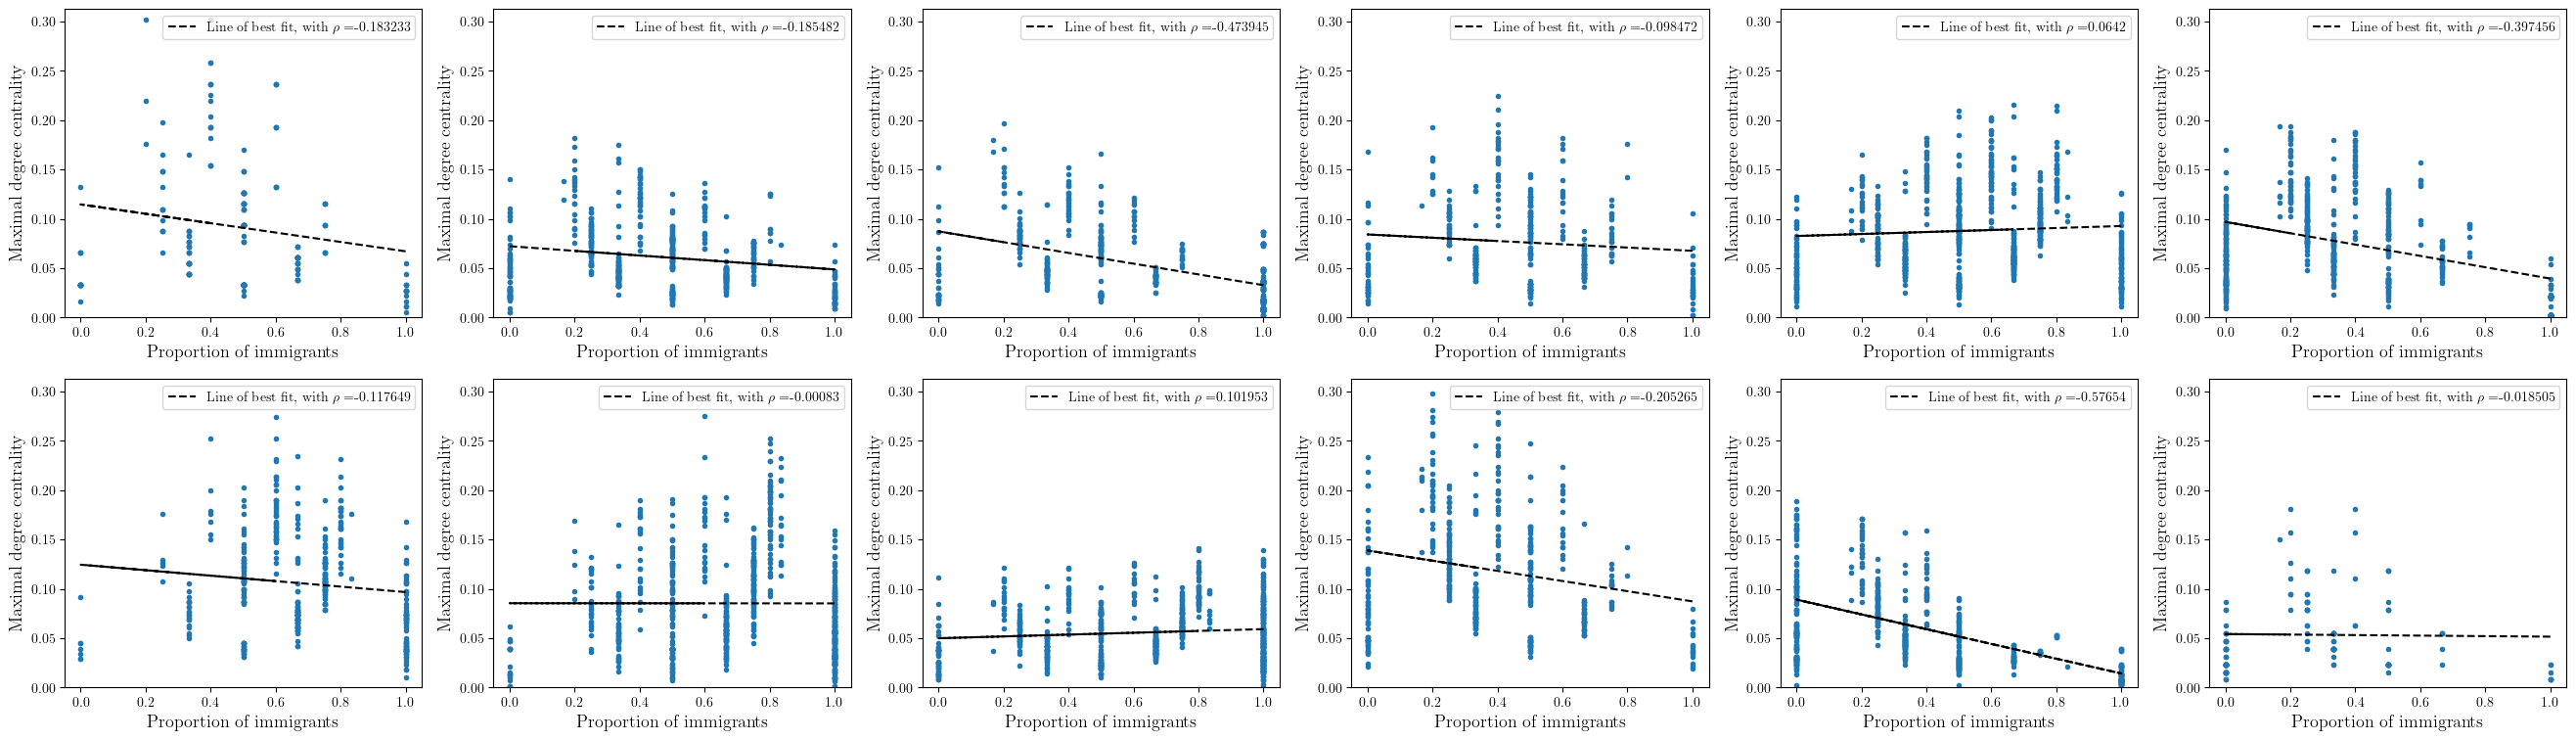

In [24]:
#Plots for immigration proportion 
fig, ax = plt.subplots(2,6)

for i in range(6):
    
    ax[0, i].plot(immis[i+6], centralities[i+6], '.')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(immis[i+6], centralities[i+6])
    R_squared = r_value ** 2
    poly1d_fn = np.poly1d([slope, intercept])
    ax[0, i].plot(immis[i+6], poly1d_fn(immis[i+6]), '--k', label = f"Line of best fit, with $\\rho=${round(r_value, 6)}")
    ax[0, i].set_xlabel("Proportion of immigrants", fontsize=13)
    ax[0, i].legend(fontsize=10)
    
    ax[1, i].plot(immis[i], centralities[i], '.')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(immis[i], centralities[i])
    R_squared = r_value ** 2
    poly1d_fn = np.poly1d([slope, intercept])
    ax[1, i].plot(immis[i], poly1d_fn(immis[i]), '--k', label = f"Line of best fit, with $\\rho=${round(r_value, 6)}")
    ax[1, i].set_xlabel(f"Proportion of immigrants", fontsize=13)
    ax[1, i].legend(fontsize=10)

for i in range(6):
    ax[0,i].set_ylim([0, max_centrality+0.01])
    ax[1,i].set_ylim([0, max_centrality+0.01])
    ax[0,i].set_ylabel("Maximal degree centrality", fontsize=13)
    ax[1,i].set_ylabel("Maximal degree centrality", fontsize=13)

fig.set_figwidth(33)
fig.set_figheight(9)


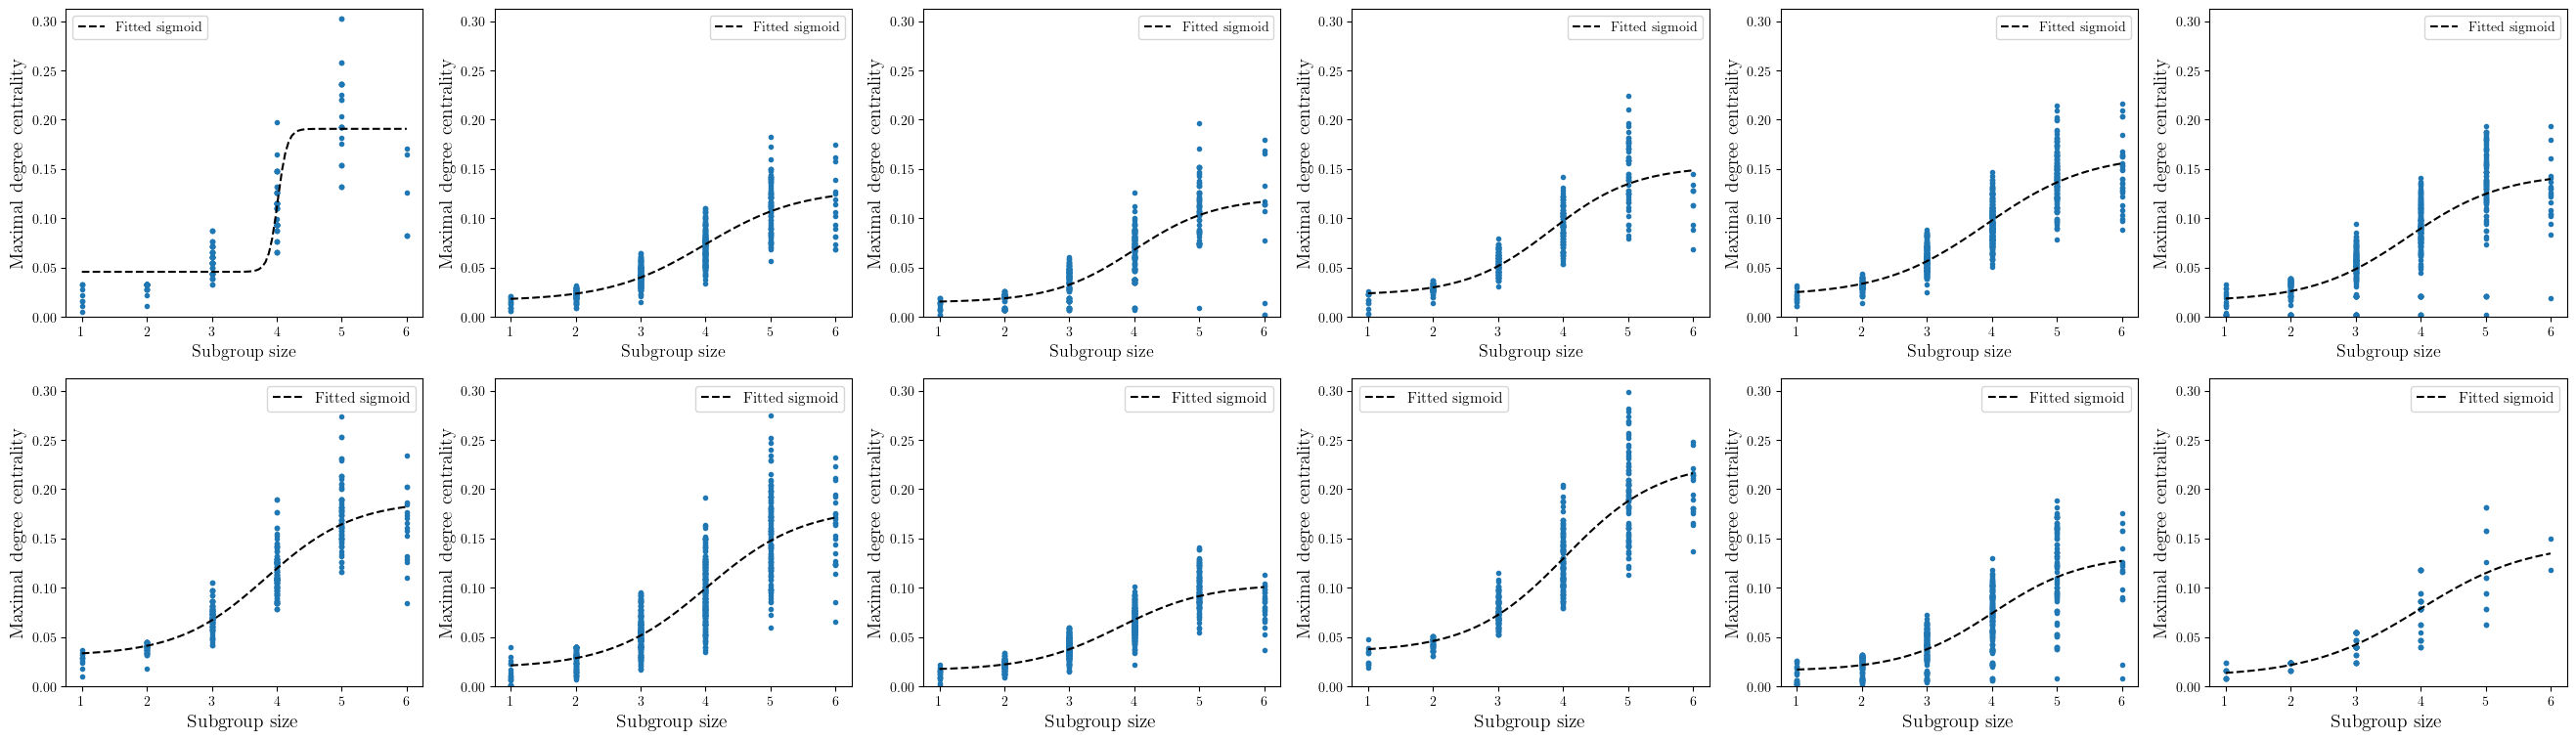

In [25]:
#Plots for subgroup size (sigmoid fit)
fig, ax = plt.subplots(2,6)

for i in range(6):
    #Dry
    ax[0, i].plot(sizes[i+6], centralities[i+6], '.')
    p0 = [max(centralities[i+6]), np.median(sizes[i+6]),1,min(centralities[i+6])]
    popt, pcov = curve_fit(sigmoid, sizes[i+6], centralities[i+6],p0, method='dogbox')    
    ax[0, i].plot(np.linspace(1, n_max, 100), sigmoid(np.linspace(1, n_max, 100), popt[0], popt[1], popt[2], popt[3]), '--k', label="Fitted sigmoid")
    ax[0, i].set_xlabel("Subgroup size", fontsize=13)
    ax[0, i].legend(fontsize=10)

    #Wet
    ax[1, i].plot(sizes[i], centralities[i], '.')
    p0 = [max(centralities[i]), np.median(sizes[i]),1,min(centralities[i])]
    popt, pcov = curve_fit(sigmoid, sizes[i], centralities[i],p0, method='dogbox')    
    ax[1, i].plot(np.linspace(1, n_max, 100), sigmoid(np.linspace(1, n_max, 100), popt[0], popt[1], popt[2], popt[3]), '--k', label="Fitted sigmoid")
    ax[1, i].set_xlabel(f"Subgroup size", fontsize=14)
    ax[1, i].legend(fontsize=11)

for i in range(6):
    ax[0,i].set_ylim([0, max_centrality+0.01])
    ax[1,i].set_ylim([0, max_centrality+0.01])
    ax[0,i].set_ylabel("Maximal degree centrality", fontsize=14)
    ax[1,i].set_ylabel("Maximal degree centrality", fontsize=14)

fig.set_figwidth(33)
fig.set_figheight(9)


### Filtration complementarity index and fruit abundance 

In [27]:
#Importing the fruit abundance index for each dataset
fruit_indices = pd.read_csv('SEASONAL_IFA.csv')

fruit_indices_CV = list(fruit_indices["cv_ifa_dbh_den"])

#For getting plots in the same order as the others:
fruit_indices_CV = [fruit_indices_CV[i] for i in [1, 3, 5, 7, 9, 11, 0, 2, 4, 6, 8, 10]]
num_individuals = [10, 18, 18, 10, 20, 13, 9, 14, 16, 12, 13, 20] #All wet seasons and then all dry

n_max = 6 

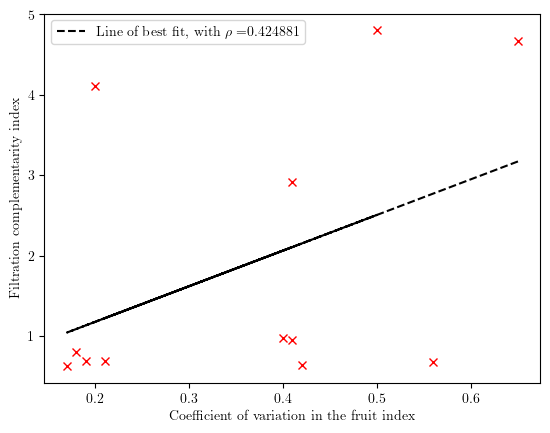

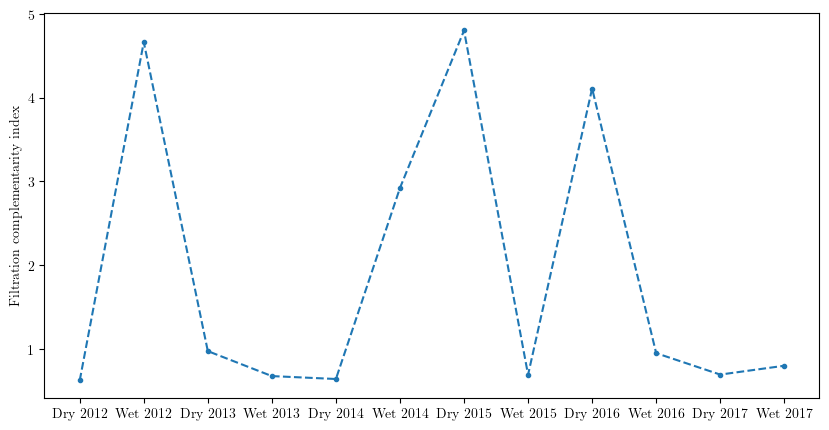

In [28]:
#Defining the filtration complementarity index, as outlined in the methods section

def compute_filtration_complementarity_index(K, num_individuals):
    persistence_list = K.persistence(homology_coeff_field=2)

    diffs = 0
    
    for i in range(len(persistence_list)):
        lower = persistence_list[i][1][0]
        upper = persistence_list[i][1][1]
        if persistence_list[i][0] != 0:
            if upper == np.inf:
                diffs += (5-lower)*(persistence_list[i][0]+1)
            else:
                diffs += (upper-lower)*(persistence_list[i][0]+1)
        elif persistence_list[i][0] == 0:
            if upper == np.inf:
                diffs += (5-lower)*(persistence_list[i][0]+1) / num_individuals
            else:
                diffs += (upper-lower)*(persistence_list[i][0]+1) / num_individuals
    
    return diffs

index_vals = [None]*12

for j in range(12):
    index_vals[j] = compute_filtration_complementarity_index(complexes[j][n_max-2], num_individuals[j])  / 5 #Normalising by the filtration length

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(fruit_indices_CV, index_vals)
R_squared = r_value ** 2
poly1d_fn = np.poly1d([slope, intercept])

plt.plot(fruit_indices_CV, poly1d_fn(fruit_indices_CV), '--k', label = f"Line of best fit, with $\\rho=${round(r_value, 6)}")
plt.plot(fruit_indices_CV, index_vals, 'xr')
plt.legend()
plt.ylabel("Filtration complementarity index")
plt.xlabel("Coefficient of variation in the fruit index")
plt.savefig("Weighted_scaledCCs_CVs.svg")
plt.show()

#Put in chronological order
index_vals_chron = [index_vals[i] for i in [6, 0, 7, 1, 8, 2, 9, 3, 10, 4, 11, 5]]

fig, ax = plt.subplots()

ax.plot(range(12), index_vals_chron, '.--')
ax.set_xticks(range(12))
labels = [item.get_text() for item in ax.get_xticklabels()]

for i in range(6):
    labels[2*i] = f"Dry {2012+i}"
    labels[2*i+1] = f"Wet {2012+i}"
    
ax.set_xticklabels(labels)
ax.set_ylabel("Filtration complementarity index")

fig.set_figwidth(10)
fig.set_figheight(5)
fig.savefig("Weighted_scaledCCs_by_season.svg")

individuals_chronological = [num_individuals[i] for i in [6, 0, 7, 1, 8, 2, 9, 3, 10, 4, 11, 5]]

d = {"Season": [item.get_text() for item in ax.get_xticklabels()], 
     "Weighted index, only CCs scaled": index_vals_chron, 
    "Number of individuals": individuals_chronological}
df = pd.DataFrame(data=d)
df.to_csv('complexity_scaling_only_CCs.csv', index=False)


##### References 
Hernández Serrano, D. & Sánchez Gómez, D. "Centrality measures in simplicial complexes:
applications of Topological Data Analysis to Network Science". Preprint. 2020. arXiv:1908.02967
